# Geospatial Image Analysis

Intro text.

[`README.md`](../README.md)

Table of contents:

1. A


## 1. Imports and Definitions

In [1]:
import sys
import os
from glob import glob

import numpy as np
import pandas as pd
import geopandas as gpd
import contextily
import matplotlib.pyplot as plt

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
from earthpy.spatial import bytescale

import rasterio as rio
from rasterio.windows import Window
from rasterio.plot import plotting_extent
from rasterio.plot import show
from rasterio.plot import reshape_as_raster, reshape_as_image

from shapely.geometry import box

# Appending aux paths
sys.path.append('../utils')
from resample_raster import resample_res, resample_scale

In [2]:
DATA_PATH = "../data/"
SCENE_1_PATH = DATA_PATH + "Scene 1 - S2A_MSIL1C_20230223T112111_N0509_R037_T30UVF_20230223T145910"
SCENE_2_PATH = DATA_PATH + "Scene 2 - S2B_MSIL1C_20230102T113359_N0509_R080_T30UWG_20230102T121121"

In [3]:
# lng/lat format in EPSG:4326 - WGS84, located in the UK
SCENE_1_BBOX = [-3.480290297664652, 54.26510479276385, -2.9010711619639267, 54.61995328561707]
SCENE_2_BBOX = [-2.815247, 55.102730, -1.450195, 55.553495]

## 2. Inspect and Visualize Scene Datasets

**IMPORTANT**: Select the scene number 1 or 2.

In [229]:
SCENE = 1

In [230]:
SCENE_PATH = SCENE_1_PATH
SCENE_BBOX = SCENE_1_BBOX
if SCENE == 2:
    SCENE_PATH = SCENE_2_PATH
    SCENE_BBOX = SCENE_2_BBOX

In [231]:
bbox = box(minx=SCENE_BBOX[0], miny=SCENE_BBOX[1], maxx=SCENE_BBOX[2], maxy=SCENE_BBOX[3], ccw=True)
gdf_bbox = gpd.GeoSeries([bbox], crs = 'epsg:4326')

In [232]:
sentinel_bands = glob(SCENE_PATH+"/*B?*.tiff")

In [233]:
gdf_points = gpd.read_file(SCENE_PATH+'/lakes.geojson')

In [234]:
gdf_points.head()

,id,geometry
0,Lake A,POINT (-3.14903 54.57731)
1,Lake B,POINT (-2.93416 54.37965)
2,Lake C,POINT (-3.07090 54.34526)


In [235]:
print(gdf_points.crs)

epsg:4326


In [236]:
sentinel_bands.sort()
sentinel_bands

['../data/Scene 1 - S2A_MSIL1C_20230223T112111_N0509_R037_T30UVF_20230223T145910/B01_COG.tiff',
 '../data/Scene 1 - S2A_MSIL1C_20230223T112111_N0509_R037_T30UVF_20230223T145910/B02_COG.tiff',
 '../data/Scene 1 - S2A_MSIL1C_20230223T112111_N0509_R037_T30UVF_20230223T145910/B03_COG.tiff',
 '../data/Scene 1 - S2A_MSIL1C_20230223T112111_N0509_R037_T30UVF_20230223T145910/B04_COG.tiff',
 '../data/Scene 1 - S2A_MSIL1C_20230223T112111_N0509_R037_T30UVF_20230223T145910/B05_COG.tiff',
 '../data/Scene 1 - S2A_MSIL1C_20230223T112111_N0509_R037_T30UVF_20230223T145910/B06_COG.tiff',
 '../data/Scene 1 - S2A_MSIL1C_20230223T112111_N0509_R037_T30UVF_20230223T145910/B07_COG.tiff',
 '../data/Scene 1 - S2A_MSIL1C_20230223T112111_N0509_R037_T30UVF_20230223T145910/B08_COG.tiff',
 '../data/Scene 1 - S2A_MSIL1C_20230223T112111_N0509_R037_T30UVF_20230223T145910/B09_COG.tiff',
 '../data/Scene 1 - S2A_MSIL1C_20230223T112111_N0509_R037_T30UVF_20230223T145910/B10_COG.tiff',
 '../data/Scene 1 - S2A_MSIL1C_20230223T

In [237]:
# FIXME: Improve with regex...
band_names = [band.split(os.sep)[-1][1:3] for band in sentinel_bands]

In [238]:
band_names

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '8A']

In [239]:
src = rio.open(sentinel_bands[1])

In [240]:
print(src.crs)

EPSG:32630


In [241]:
gdf_points = gdf_points.to_crs(src.crs)

In [242]:
gdf_points

,id,geometry
0,Lake A,POINT (490366.740 6047766.663)
1,Lake B,POINT (504276.214 6025765.035)
2,Lake C,POINT (495390.986 6021939.091)


In [243]:
gdf_bbox = gdf_bbox.to_crs(src.crs)

In [244]:
gdf_bbox

0    POLYGON ((506443.467 6013022.518, 506388.006 6...
dtype: geometry

In [245]:
src.count

1

In [246]:
src.width, src.height

(10980, 10980)

In [247]:
src.bounds # bbox

BoundingBox(left=399960.0, bottom=5990220.0, right=509760.0, top=6100020.0)

In [248]:
src.offsets

(0.0,)

In [249]:
src.res # resolution

(10.0, 10.0)

In [250]:
src.transform

Affine(10.0, 0.0, 399960.0,
       0.0, -10.0, 6100020.0)

In [251]:
src.profile

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 10980, 'height': 10980, 'count': 1, 'crs': CRS.from_epsg(32630), 'transform': Affine(10.0, 0.0, 399960.0,
       0.0, -10.0, 6100020.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

In [252]:
# Open rasters with Rasterio
# Resample/Resize if needed: I would take the minimum resolution (60m)
images = []
xres = 60
yres = 60
resample = True
for i in sentinel_bands:
    with rio.open(i, 'r') as src:
        img = None
        profile = None
        if resample:
            img, profile = resample_res(src, xres, yres)
        else:
            img, profile = src.read(1), src.profile
        images.append(img)
        # Display
        print(f"New shape: {img.shape}, org. resolution: {src.res}")

New shape: (1, 1830, 1830), org. resolution: (60.0, 60.0)
New shape: (1, 1830, 1830), org. resolution: (10.0, 10.0)
New shape: (1, 1830, 1830), org. resolution: (10.0, 10.0)
New shape: (1, 1830, 1830), org. resolution: (10.0, 10.0)
New shape: (1, 1830, 1830), org. resolution: (20.0, 20.0)
New shape: (1, 1830, 1830), org. resolution: (20.0, 20.0)
New shape: (1, 1830, 1830), org. resolution: (20.0, 20.0)
New shape: (1, 1830, 1830), org. resolution: (10.0, 10.0)
New shape: (1, 1830, 1830), org. resolution: (60.0, 60.0)
New shape: (1, 1830, 1830), org. resolution: (60.0, 60.0)
New shape: (1, 1830, 1830), org. resolution: (20.0, 20.0)
New shape: (1, 1830, 1830), org. resolution: (20.0, 20.0)
New shape: (1, 1830, 1830), org. resolution: (20.0, 20.0)


In [253]:
# Stack all image channels/bands
images_array = np.stack(images).squeeze()

In [254]:
images_array.shape

(13, 1830, 1830)

In [255]:
images_array.min()

0

In [256]:
images_array.max()

14978

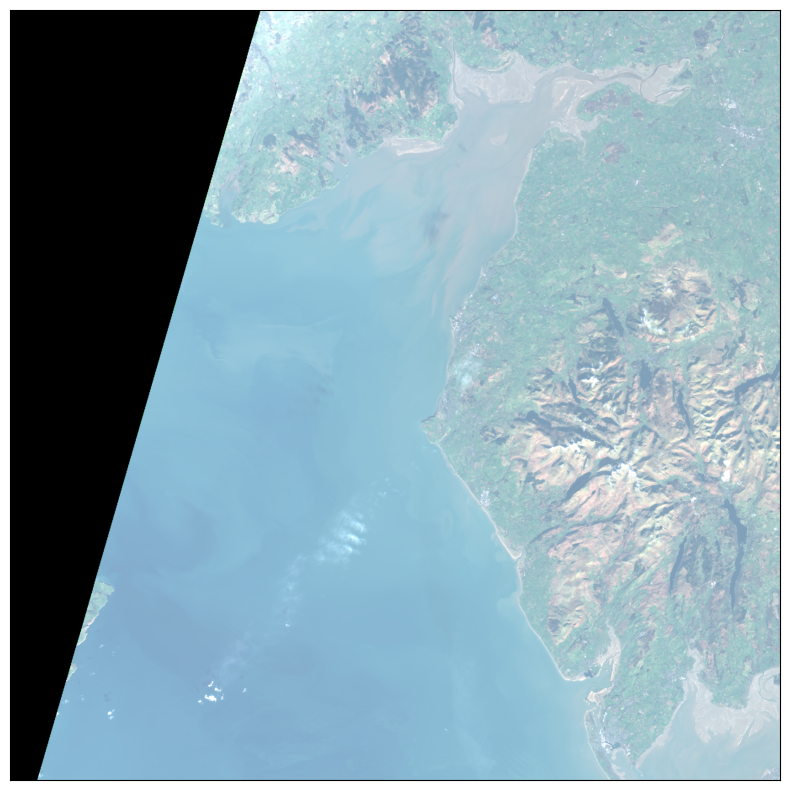

In [257]:
# Plot RGB image
rgb = ep.plot_rgb(images_array[1:4], 
                  rgb=(2,1,0), # (default = (0, 1, 2))) indices of the three RGB bands,
                  stretch=True, # apply linear stretch
                  str_clip=0.2, # pcnt of clip in linear stretch, default 2 = 2%
                  figsize=(10, 10))
plt.show()

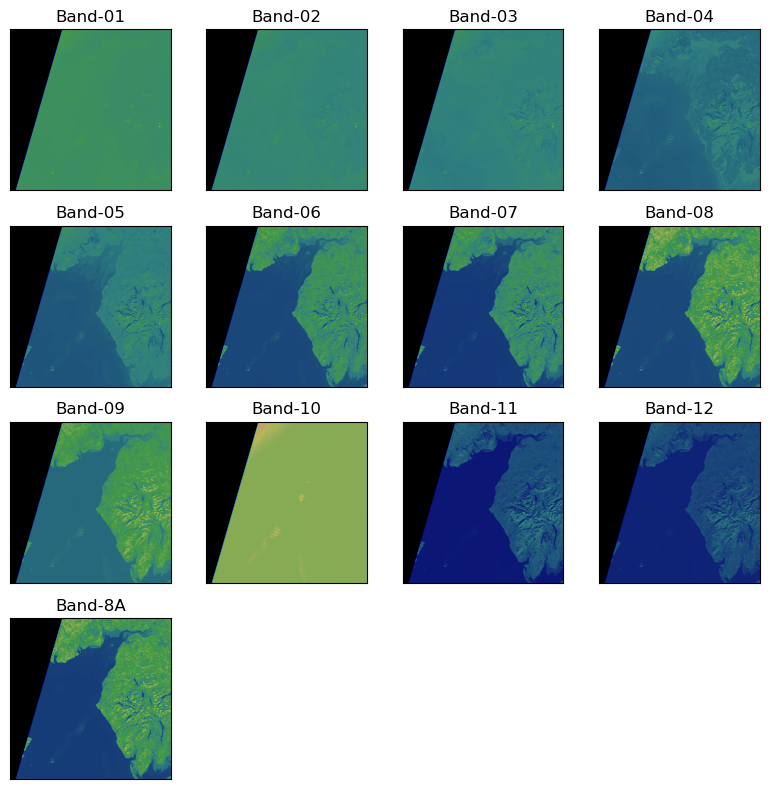

In [258]:
# Plot all bands
ep.plot_bands(images_array, 
              cmap='gist_earth',
              title=[f"Band-{name}" for name in band_names],
              figsize=(8, 8),
              cols=4,
              cbar=False)
plt.show()

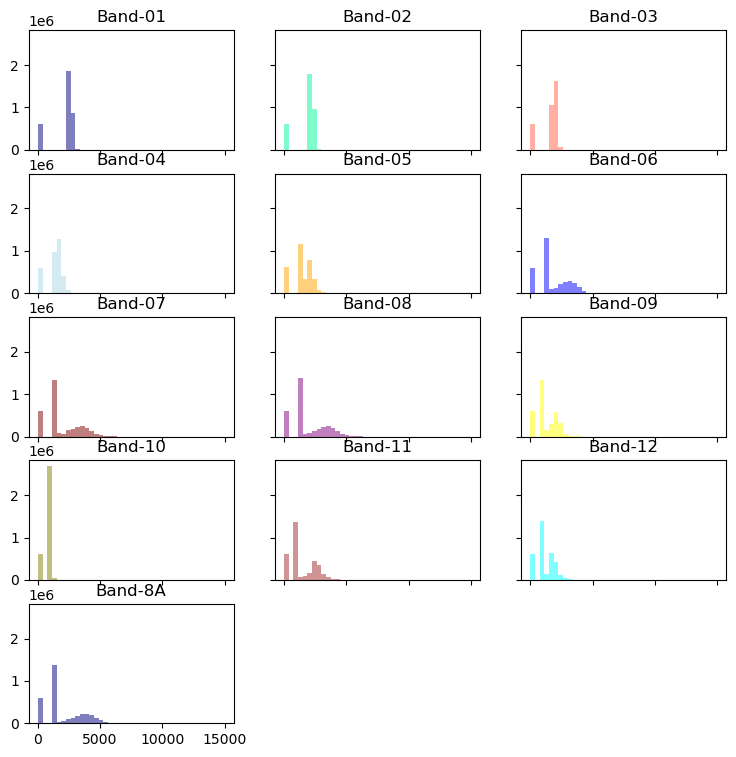

In [259]:
# Pixel value distributions: histograms
colors = ['navy', 'MediumSpringGreen', 'tomato', 'lightblue', 'orange', 'blue',
          'maroon', 'purple', 'yellow', 'olive', 'brown', 'cyan', 'navy']
ep.hist(images_array, 
        colors = colors,
        #title=[f'Band-{i}' for i in range(1, len(sentinel_bands)+1)], 
        title=[f'Band-{name}' for name in band_names], 
        cols=3, 
        alpha=0.5, 
        figsize=(9, 9),
        bins=40)
plt.show()

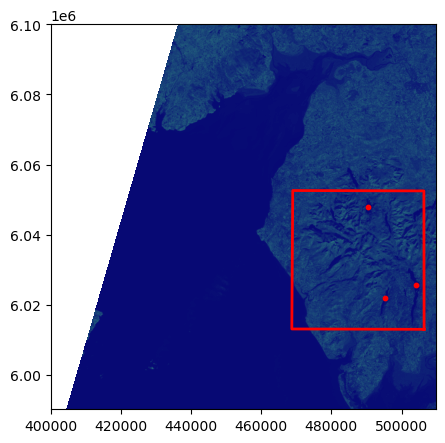

In [260]:
# Select a band and plot geometries on it (points & cropping bbox)
band_name = sentinel_bands[6]
with rio.open(band_name, 'r') as src:
    fig, ax = plt.subplots(figsize=(5, 5))
    rio.plot.show(src, ax=ax, adjust=True, cmap="gist_earth")
    gdf_points.plot(ax=ax, markersize=10, color='red')
    #gdf_bbox.plot(ax=ax, color='red', facecolor="green")
    ax.plot(*gdf_bbox[0].exterior.xy, color='red', linewidth=2)
    plt.show()

## 3. Resample, Crop and Persist Images

In [261]:
def resample_persist_band(input_path,
                          output_path,
                          resolution=(60,60)):
    """Resample band pixelmap to spcified resolution
    and persist.
    
    Args:
        input_path (str): input filename of the band/channel image pixelmap
        output_path (str): output filename of the band/channel image pixelmap
        resolution (tuple[float]): x and y resolution to resample

    Returns: None
    """
    xres = resolution[0]
    yres = resolution[1]
    with rio.open(input_path, 'r') as src:
        img, profile = resample_res(src, xres, yres)
    
    with rio.open(output_path, "w", **profile) as dataset:
        dataset.write(img)

In [262]:
# Create a folder to store all processed images images
try:
    output_path = os.path.join(SCENE_PATH, "processed")
    os.mkdir(output_path)
except FileExistsError as err:
    print("Folder already exists.")

Folder already exists.


In [263]:
# Resample and save all files
for band in sentinel_bands:
    input_file = band
    filename = input_file.split(os.sep)[-1]
    output_file = os.path.join(SCENE_PATH, "processed", filename)
    try:
        assert os.path.isfile(input_file)
        resample_persist_band(input_path=input_file,
                              output_path=output_file,
                              resolution=(60,60))
    except AssertionError as err:
        print(f"resample_persist_band: input_file does not exist: {input_file}")

In [264]:
def crop_persist_band(input_path, output_path, shapes):
    """Load band from input path,
    crop it according to the geometries in shapes
    and persist to filepath in output_path.
    
    Args:
        input_path (str): path of the band file
        output_path (str): path to persist cropped band
        shapes (gepandas.GeoSeries): iterable with geometries to crop
    
    Returns:
        out_image (numpy.ndarray): copped image/band array
        out_meta (dict): dictionary with band information
            (i.e., CRS, affine transformation matrix, etc.)
    """
    with rio.open(input_file, "r") as src:
        out_image, out_transform = rio.mask.mask(src,
                                                 shapes,
                                                 crop=True)
        out_meta = src.meta
        out_meta.update({"driver": "GTiff",
                         "height": out_image.shape[1],
                         "width": out_image.shape[2],
                         "transform": out_transform})
        with rio.open(output_file, "w", **out_meta) as dest:
            dest.write(out_image)
        
    return out_image, out_meta

In [265]:
input_file = sentinel_bands[8]
output_file = "test_raster.tiff"
out_image, out_meta = crop_persist_band(input_path=input_file,
                                        output_path=output_file,
                                        shapes=gdf_bbox)

In [266]:
out_image.std()

524.3262926283547

In [267]:
out_meta

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': 0.0,
 'width': 630,
 'height': 660,
 'count': 1,
 'crs': CRS.from_epsg(32630),
 'transform': Affine(60.0, 0.0, 468660.0,
        0.0, -60.0, 6052620.0)}

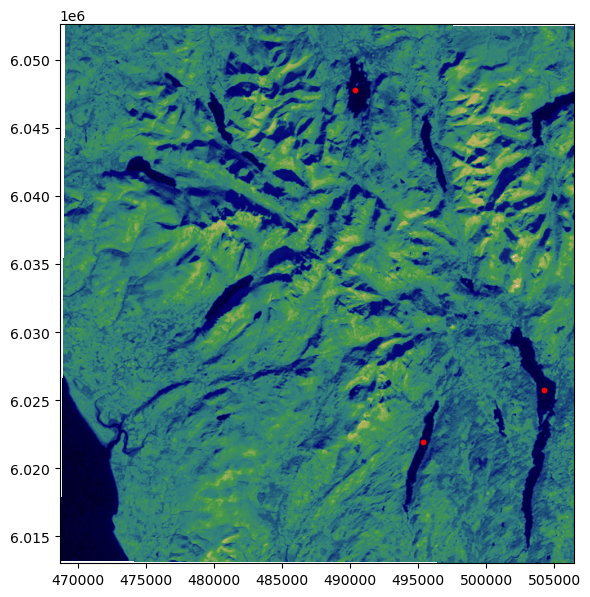

In [268]:
band_name = output_file
with rio.open(band_name, 'r') as src:
    fig, ax = plt.subplots(figsize=(7, 7))
    rio.plot.show(src, ax=ax, adjust=True, cmap="gist_earth")
    gdf_points.plot(ax=ax, markersize=10, color='red')
    plt.show()

In [269]:
# Get paths of resampled bands
sentinel_bands = glob(os.path.join(SCENE_PATH, "processed", "*B?*.tiff"))
sentinel_bands.sort()

In [270]:
# Crop all bands
for band in sentinel_bands:
    input_file = band
    filename = input_file.split(os.sep)[-1]
    output_file = os.path.join(SCENE_PATH, "processed", filename)
    try:
        assert os.path.isfile(input_file)
        _, _ = crop_persist_band(input_path=input_file,
                                 output_path=output_file,
                                 shapes=gdf_bbox)
    except AssertionError as err:
        print(f"crop_persist_band: input_file does not exist: {input_file}")

In [271]:
def load_band_image(filename, resample=False, resolution=(60,60)):
    """Load a band file and resample (resize) it
    if required.
    
    Args:
        filename (str): filename of the band/channel image pixelmap
        resample (bool): resample/resize or not (default: True)
        resolution (tuple[float]): x and y resolution to resample

    Returns:
        img (numpy.ndarray): band array, image
        profile (dict): dictionary with band profile meta-info
        band_name (str): band name (1, 2, ...)
    """
    xres = resolution[0]
    yres = resolution[1]
    resample = True
    # FIXME: use regex in future, or a more generic way...
    band_name = filename.split(os.sep)[-1][1:3]
    with rio.open(filename, 'r') as src:
        img = None
        profile = None
        if resample:
            img, profile = resample_res(src, xres, yres)
        else:
            img, profile = src.read(1), src.profile
            rio.plot.show(src, ax=ax, adjust=True, cmap="gist_earth")
            plt.show()

    return img, profile, band_name

In [272]:
test_filename = "../data/Scene 1 - S2A_MSIL1C_20230223T112111_N0509_R037_T30UVF_20230223T145910/processed/B01_COG.tiff"
img, profile, band_name = load_band_image(filename=test_filename,
                                          resample=True,
                                          resolution=(60,60))

In [273]:
# Load all cropped bands
sentinel_bands = glob(os.path.join(SCENE_PATH, "processed", "*B?*.tiff"))
sentinel_bands.sort()
images = []
profiles = []
band_names = []
for band_filename in sentinel_bands:
    try:
        assert os.path.isfile(band_filename)
        img, profile, band_name = load_band_image(filename=band_filename,
                                                  resample=False,
                                                  resolution=(60,60))
        images.append(img)
        profiles.append(profile)
        band_names.append(band_name)        
    except AssertionError as err:
        print(f"load_band_image: band_filename does not exist: {band_filename}")

In [274]:
for i in images:
    print(i.shape)

(1, 660, 630)
(1, 660, 630)
(1, 660, 630)
(1, 660, 630)
(1, 660, 630)
(1, 660, 630)
(1, 660, 630)
(1, 660, 630)
(1, 660, 630)
(1, 660, 630)
(1, 660, 630)
(1, 660, 630)
(1, 660, 630)


In [275]:
# Stack all image channels/bands
images_array = np.stack(images).squeeze()

In [276]:
images_array.shape

(13, 660, 630)

In [277]:
band_names

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '8A']

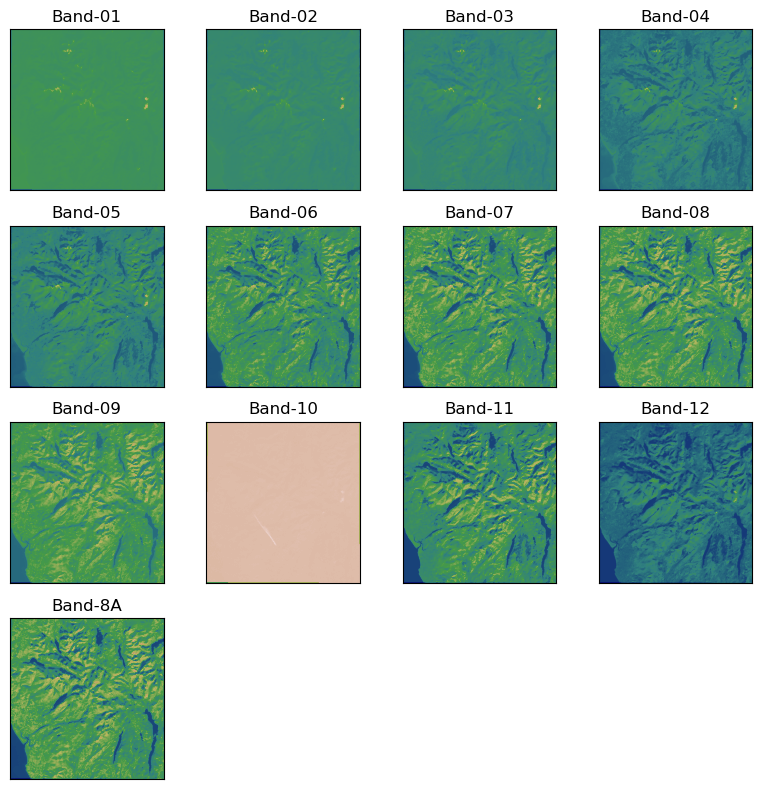

In [278]:
# Plot all bands
ep.plot_bands(images_array, 
              cmap='gist_earth',
              title=[f"Band-{name}" for name in band_names],
              figsize=(8, 8),
              cols=4,
              cbar=False)
plt.show()

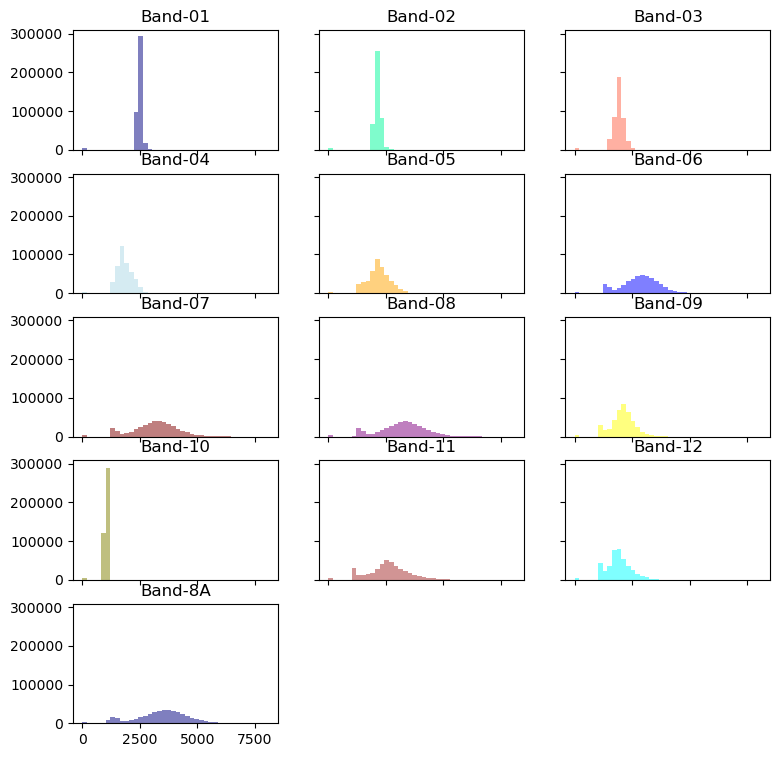

In [279]:
# Pixel value distributions: histograms
colors = ['navy', 'MediumSpringGreen', 'tomato', 'lightblue', 'orange', 'blue',
          'maroon', 'purple', 'yellow', 'olive', 'brown', 'cyan', 'navy']
ep.hist(images_array, 
        colors = colors,
        #title=[f'Band-{i}' for i in range(1, len(sentinel_bands)+1)], 
        title=[f'Band-{name}' for name in band_names], 
        cols=3, 
        alpha=0.5, 
        figsize=(9, 9),
        bins=40)
plt.show()

In [280]:
# Low standard deviations indicate very concentrated histograms,
# i.e., pixel values are not very distributed, i.e., few information contained
means = [images_array[b].mean() for b in range(images_array.shape[0])]
stds = [images_array[b].std() for b in range(images_array.shape[0])]
for b, m in enumerate(means):
    print(f"band {band_names[b]}: mean = {m}; std = {images_array[b].std()}")

band 01: mean = 2472.6200360750363; std = 265.09110622667015
band 02: mean = 2129.1565584415584; std = 254.02441563955546
band 03: mean = 1916.7445382395383; std = 279.71804252339984
band 04: mean = 1840.4430375180375; std = 373.6484050205747
band 05: mean = 2174.737291967292; std = 513.938747193325
band 06: mean = 2828.894102934103; std = 819.2112595219932
band 07: mean = 3126.3000745550744; std = 970.7887140003193
band 08: mean = 3179.462121212121; std = 1011.1707821514573
band 09: mean = 2058.5370707070706; std = 524.3262926283547
band 10: mean = 1007.410634920635; std = 96.92432769493878
band 11: mean = 2624.945404040404; std = 901.9951461769807
band 12: mean = 1914.0133886483886; std = 552.5729559445801
band 8A: mean = 3446.8070803270803; std = 1137.7046199889887


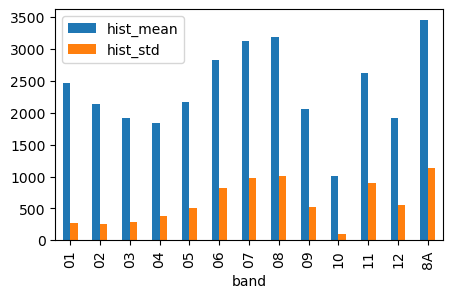

In [281]:
df_hist = pd.DataFrame({'band': band_names, 'hist_mean': means, 'hist_std': stds}).set_index('band')
df_hist.plot(kind='bar', figsize=(5,3))
plt.savefig(f'../assets/scene_{SCENE}_hist_params.png',dpi=300,transparent=False,bbox_inches='tight')